# HW4

### NAME: Yuhao Wang
### UNI: yw3204

### Problem 1

1. $d^2(x, x^\prime) = \langle x, x\rangle - 2\langle x, x^\prime \rangle + \langle x', x^\prime \rangle$

2. $d_K^2(x, x^\prime) = \langle \phi(x), \phi(x)\rangle - 2\langle \phi(x), \phi(x^\prime) \rangle + \langle \phi(x^\prime), \phi(x^\prime) \rangle = K(x, x)-2K(x, x^\prime)+K(x^\prime, x^\prime)$

3. It calculates the Euclidean distance in the feature space w.r.t the feature mapping $\phi$.

### Problem 2

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

plt.style.use("ggplot")
%matplotlib inline

In [7]:
# load data
credit_data = pd.read_csv("/Users/apple/Desktop/semester_2/4.Stat_ML/hw/hw4/Credit.csv")
credit_data = credit_data.drop(credit_data.columns[[0]], axis = 1)

# dummy variables 
credit_data["Gender"] = [0 if i == "Female" else 1 for i in credit_data["Gender"]]
credit_data["Student"] = [0 if i == "No" else 1 for i in credit_data["Student"]]
credit_data["Married"] = [0 if i == "No" else 1 for i in credit_data["Married"]]

credit_data["Asian"] = [1 if i == "Asian" else 0 for i in credit_data["Ethnicity"]]
credit_data["Ethnicity"] = [1 if i == "Caucasian" else 0 for i in credit_data["Ethnicity"]]
credit_data = credit_data.rename(columns={'Ethnicity': 'Caucasian'})

Y = credit_data.Balance
X = credit_data.drop(columns = 'Balance', axis = 1)
k = len(X.columns)

In [8]:
# reference to: "https://xavierbourretsicotte.github.io/subset_selection.html"
# helper function
def fit_linear_reg(X, Y):
    # Fit linear regression model and return RSS
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X, Y)
    RSS = mean_squared_error(Y, model.predict(X)) * len(Y)
    return RSS

In [9]:
# 1.
# best subset
RSS_list, feature_list, numb_features = [], [], []

# Looping over k = 1 to k = 11 features in X
for p in range(1, k+1):
    
    # Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns, p):
        tmp_result = fit_linear_reg(X[list(combo)], Y)   # Store temp result 
        RSS_list.append(tmp_result)                  
        feature_list.append(combo)
        numb_features.append(len(combo))   

# Store in DataFrame
model_pool = pd.DataFrame({'numb_features': numb_features, 'RSS': RSS_list, 'features':feature_list})
best_models = model_pool[model_pool.groupby('numb_features')['RSS'].transform(min) == model_pool['RSS']]
best_RSS = list(best_models.RSS)

In [13]:
# forward stepwise
remaining_features = list(X.columns.values)
tmp_features = []
forward_RSS = []
fd_list = dict()

for i in range(1, k+1):
    tmp_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features, 1):
        RSS = fit_linear_reg(X[list(combo) + tmp_features], Y)   #Store temp result 
        if RSS < tmp_RSS:
            tmp_RSS = RSS
            best_feature = combo[0]

    #Updating variables for next loop
    tmp_features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    forward_RSS.append(tmp_RSS)
    fd_list[i] = tmp_features.copy()

In [21]:
# backward stepwise
remaining_features = list(X.columns.values)
backward_RSS = [] 
bd_list = dict()

backward_RSS.insert(0, forward_RSS[10])
bd_list[k] = fd_list[k]

for i in range(k-1, 0, -1):
    tmp_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features, 1):
        remaining_features.remove(combo[0])
        RSS = fit_linear_reg(X[remaining_features], Y)  
        remaining_features.append(combo[0])

        if RSS < tmp_RSS:
            tmp_RSS = RSS
            worst_feature = combo[0]

    # Updating variables for next loop
    remaining_features.remove(worst_feature)
    
    # Saving values for plotting
    backward_RSS.append(tmp_RSS)
    bd_list[i] = remaining_features.copy()

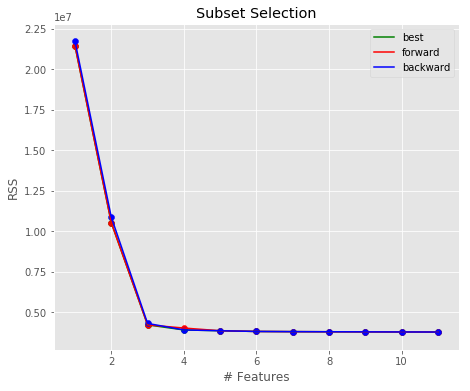

In [96]:
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(range(1, 12), best_RSS, color = 'g')
ax.plot(range(1, 12), best_RSS, color = 'g', label="best")

ax.scatter(range(1, 12), forward_RSS, color = 'r')
ax.plot(range(1, 12), forward_RSS, color = 'r', label = "forward")

ax.scatter(range(11, 0, -1), backward_RSS, color = 'b')
ax.plot(range(11, 0, -1), backward_RSS, color = 'b', label="backward")

ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('Subset Selection')
ax.legend()

plt.show()

In [52]:
# 2.
n = len(Y)
sga_sqre = best_RSS[k-1]/n

# Cp and BIC for best subset
best_Cp, best_BIC = [], []
for i in range(k):
    best_Cp.append(1/n * (best_RSS[i]+2*(i+1)*sga_sqre))
    best_BIC.append(1/n * (best_RSS[i]+np.log(n)*(i+1)*sga_sqre))
    
# Cp and BIC for forward stepwise
fd_Cp, fd_BIC = [], []
for i in range(k):
    fd_Cp.append(1/n * (forward_RSS[i]+2*(i+1)*sga_sqre))
    fd_BIC.append(1/n * (forward_RSS[i]+np.log(n)*(i+1)*sga_sqre))

# Cp and BIC for backward stepwise
bd_Cp, bd_BIC = [], []
for i in range(k):
    bd_Cp.append(1/n * (backward_RSS[i]+2*(k-i)*sga_sqre))
    bd_BIC.append(1/n * (backward_RSS[i]+np.log(n)*(k-i)*sga_sqre))

In [53]:
print(np.argmin(best_Cp))
print(np.argmin(best_BIC))
print(list(best_models.features)[5])
print(list(best_models.features)[3])

5
3
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Student')
('Income', 'Limit', 'Cards', 'Student')


For best subset selection, we choose the 6th model when using $C_p$ index and the 4th model when using BIC.

In [68]:
print(np.argmin(fd_Cp))
print(np.argmin(fd_BIC))
print(fd_list[6])
print(fd_list[5])

5
4
['Rating', 'Income', 'Student', 'Limit', 'Cards', 'Age']
['Rating', 'Income', 'Student', 'Limit', 'Cards']


For forward stepwise selection, we choose the 6th model when using $C_p$ index and the 5th model when using BIC.

In [69]:
print(np.argmin(bd_Cp))
print(np.argmin(bd_BIC))
print(bd_list[k-5])
print(bd_list[k-7])

5
7
['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Student']
['Income', 'Limit', 'Cards', 'Student']


For backward stepwise selection, we choose the 6th model when using $C_p$ index and the 4th model when using BIC.

### Problem 3

In [97]:
from sklearn import svm
from sklearn.model_selection import KFold
import seaborn as sns

In [98]:
# load data
x5 = pd.read_csv("/Users/apple/Desktop/semester_2/4.Stat_ML/hw/hw4/train.5.txt", header = None)
x6 = pd.read_csv("/Users/apple/Desktop/semester_2/4.Stat_ML/hw/hw4/train.6.txt", header = None)

y5 = np.repeat(-1, x5.shape[0])
y6 = np.repeat(1, x6.shape[0])

x = pd.concat([x5, x6], ignore_index=True)
y = np.concatenate([y5, y6])

# split into test and train data
np.random.seed(0)
ind = np.random.choice(len(y), int(0.2*len(y)), replace=False)
test_ind = [i in ind for i in range(len(y))]
train_ind = [i not in ind for i in range(len(y))]

test_x = x.loc[test_ind, :]
test_x = test_x.reset_index(drop=True)
test_y = y[test_ind, ]

train_x = x.loc[train_ind, :]
train_x = train_x.reset_index(drop=True)
train_y = y[train_ind, ]

In [100]:
# cross validation error
def cv(x, y, m, k=4):
    '''
    x: dataframe
    y: list
    m: model
    '''
    kf = KFold(n_splits=k)
    err = []
    
    for train_ind, val_ind in kf.split(x):
        x_train, x_val = x.loc[train_ind], x.loc[val_ind]
        y_train, y_val = y[train_ind], y[val_ind]
        m.fit(x_train, y_train)
        err.append(sum(m.predict(x_val) != y_val))
    
    cv_err = np.sum(err)/len(y)
    return cv_err

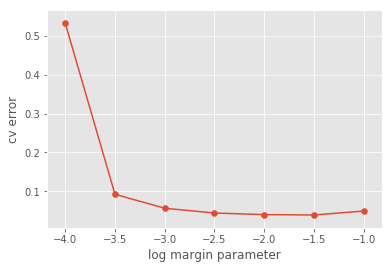

In [122]:
# 1. (a)
# margin parameters
Cs = [1e-4, 10**(-3.5), 1e-3, 10**(-2.5), 1e-2, 10**(-1.5), 1e-1]
CV_errs = []

for i in Cs:
    tmp_svm = svm.SVC(kernel="linear", C = i)
    CV_errs.append(cv(train_x, train_y, tmp_svm))
    
plt.plot(np.log10(Cs), CV_errs)
plt.scatter(np.log10(Cs), CV_errs)

plt.xlabel("log margin parameter")
plt.ylabel("cv error")

plt.show()

For the linear kernel, we choose margin parameter as 0.01.

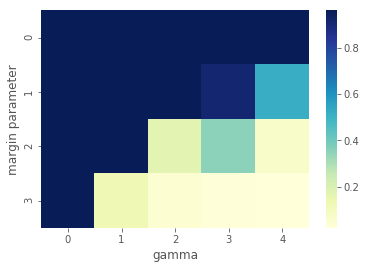

In [123]:
# 1. (b)
Cs = [1e-2, 10**(-1.5), 1e-1, 1]
gammas = [1e-5, 1e-4, 1e-3, 0.02, 0.01]

CV_mat = [[] for i in range(len(Cs))]

for i in range(len(Cs)):
    for j in range(len(gammas)):
        tmp_svm = svm.SVC(C = Cs[i], gamma = gammas[j])
        CV_mat[i].append(cv(train_x, train_y, tmp_svm))
    
sns.heatmap(CV_mat, cmap="YlGnBu")
plt.xlabel("gamma")
plt.ylabel("margin parameter")
plt.show()

For the RBF kernel, we choose magin parameter as 1 and gamma as 0.01.

In [128]:
# 2.
# set model
lin_svm_final = svm.SVC(kernel="linear", C = 0.01)
RBF_svm_final = svm.SVC(C = 1, gamma = 0.01)

# train
lin_svm_final.fit(train_x, train_y)
RBF_svm_final.fit(train_x, train_y)

# test
lin_test_err = np.mean(lin_svm_final.predict(test_x) != test_y)
RBF_test_err = np.mean(RBF_svm_final.predict(test_x) != test_y)

print(lin_test_err)
print(RBF_test_err)

0.00819672131147541
0.004098360655737705


According to the result above, the RBF SVM outperforms the linear SVM w.r.t the generalization error.